In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# This is just to show that we using the GPU cus I am doing this locally

Using device: cuda


In [2]:
base_dir = r"C:\Users\Samarth Kadam\Downloads\Skin_cancer"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

size = (224, 224)

train_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [3]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

targets = [sample[1] for sample in train_dataset.samples]
class_sample_count = np.array([len(np.where(np.array(targets) == t)[0]) for t in np.unique(targets)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in targets])
samples_weight = torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Class mapping:", train_dataset.class_to_idx)


Class mapping: {'benign': 0, 'malignant': 1}


In [4]:
model = models.resnet34(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 1)  # Binary output bruh :)
model = model.to(device)


C:\Users\Samarth Kadam\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Samarth Kadam\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [6]:
from tqdm import tqdm

num_epochs = 15
best_val_loss = float('inf')
best_model_wts = None

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    pbar = tqdm(train_loader, desc=f"Training", leave=True, ncols=80)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    avg_train_loss = np.mean(train_losses)

    model.eval()
    val_losses, val_preds, val_labels = [], [], []
    pbar = tqdm(test_loader, desc=f"Validation", leave=True, ncols=80)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    avg_val_loss = np.mean(val_losses)

    scheduler.step(avg_val_loss)
    val_preds_binary = [1 if p > 0.5 else 0 for p in val_preds]
    acc = accuracy_score(val_labels, val_preds_binary)
    prec = precision_score(val_labels, val_preds_binary)
    rec = recall_score(val_labels, val_preds_binary)
    f1 = f1_score(val_labels, val_preds_binary)

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = model.state_dict()
model.load_state_dict(best_model_wts)


Epoch 1/15


Validation: 100%|██████████████████| 96/96 [00:19<00:00,  4.93it/s, loss=1.6242]


Train Loss: 0.3141 | Val Loss: 0.4274 | Acc: 0.8119 | Prec: 0.8456 | Rec: 0.7340 | F1: 0.7859

Epoch 2/15


Validation: 100%|██████████████████| 96/96 [00:21<00:00,  4.45it/s, loss=1.2790]


Train Loss: 0.2560 | Val Loss: 0.3941 | Acc: 0.8456 | Prec: 0.8374 | Rec: 0.8333 | F1: 0.8354

Epoch 3/15


Validation: 100%|██████████████████| 96/96 [00:22<00:00,  4.27it/s, loss=0.7366]


Train Loss: 0.2215 | Val Loss: 0.3181 | Acc: 0.8678 | Prec: 0.8439 | Rec: 0.8819 | F1: 0.8625

Epoch 4/15


Validation: 100%|██████████████████| 96/96 [00:21<00:00,  4.39it/s, loss=0.5194]


Train Loss: 0.1912 | Val Loss: 0.2510 | Acc: 0.9096 | Prec: 0.8596 | Rec: 0.9653 | F1: 0.9094

Epoch 5/15


Validation: 100%|██████████████████| 96/96 [00:20<00:00,  4.77it/s, loss=1.6126]


Train Loss: 0.1696 | Val Loss: 0.2578 | Acc: 0.8985 | Prec: 0.9216 | Rec: 0.8569 | F1: 0.8881

Epoch 6/15


Validation: 100%|██████████████████| 96/96 [00:19<00:00,  4.91it/s, loss=0.4629]


Train Loss: 0.1490 | Val Loss: 0.2693 | Acc: 0.8978 | Prec: 0.8376 | Rec: 0.9708 | F1: 0.8993

Epoch 7/15


Validation: 100%|██████████████████| 96/96 [00:21<00:00,  4.54it/s, loss=0.6794]


Train Loss: 0.1243 | Val Loss: 0.2667 | Acc: 0.9063 | Prec: 0.9109 | Rec: 0.8875 | F1: 0.8991

Epoch 8/15


Validation: 100%|██████████████████| 96/96 [00:21<00:00,  4.46it/s, loss=0.7794]


Train Loss: 0.1117 | Val Loss: 0.2351 | Acc: 0.9259 | Prec: 0.8915 | Rec: 0.9590 | F1: 0.9241

Epoch 9/15


Validation: 100%|██████████████████| 96/96 [00:19<00:00,  4.93it/s, loss=0.7726]


Train Loss: 0.1000 | Val Loss: 0.1909 | Acc: 0.9357 | Prec: 0.9313 | Rec: 0.9319 | F1: 0.9316

Epoch 10/15


Validation: 100%|██████████████████| 96/96 [00:19<00:00,  4.87it/s, loss=0.1677]


Train Loss: 0.0932 | Val Loss: 0.1940 | Acc: 0.9409 | Prec: 0.9106 | Rec: 0.9694 | F1: 0.9391

Epoch 11/15


Validation: 100%|██████████████████| 96/96 [00:19<00:00,  4.88it/s, loss=0.8064]


Train Loss: 0.0864 | Val Loss: 0.2642 | Acc: 0.9200 | Prec: 0.8960 | Rec: 0.9389 | F1: 0.9169

Epoch 12/15


Validation: 100%|██████████████████| 96/96 [00:19<00:00,  4.95it/s, loss=0.2365]


Train Loss: 0.0884 | Val Loss: 0.1574 | Acc: 0.9491 | Prec: 0.9246 | Rec: 0.9708 | F1: 0.9472

Epoch 13/15


Validation: 100%|██████████████████| 96/96 [00:19<00:00,  4.91it/s, loss=0.2136]


Train Loss: 0.0778 | Val Loss: 0.1816 | Acc: 0.9465 | Prec: 0.9388 | Rec: 0.9479 | F1: 0.9433

Epoch 14/15


Validation: 100%|██████████████████| 96/96 [00:19<00:00,  4.88it/s, loss=0.0478]


Train Loss: 0.0744 | Val Loss: 0.3236 | Acc: 0.9220 | Prec: 0.8686 | Rec: 0.9826 | F1: 0.9221

Epoch 15/15


Validation: 100%|██████████████████| 96/96 [00:19<00:00,  4.85it/s, loss=0.6174]

Train Loss: 0.0644 | Val Loss: 0.2253 | Acc: 0.9354 | Prec: 0.9429 | Rec: 0.9181 | F1: 0.9303


<All keys matched successfully>

In [7]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

print("Final Test Accuracy:", accuracy_score(all_labels, all_preds))
print("Final Test Precision:", precision_score(all_labels, all_preds))
print("Final Test Recall:", recall_score(all_labels, all_preds))
print("Final Test F1 Score:", f1_score(all_labels, all_preds))


Final Test Accuracy: 0.9353574926542605
Final Test Precision: 0.9429386590584878
Final Test Recall: 0.9180555555555555
Final Test F1 Score: 0.9303307529908516


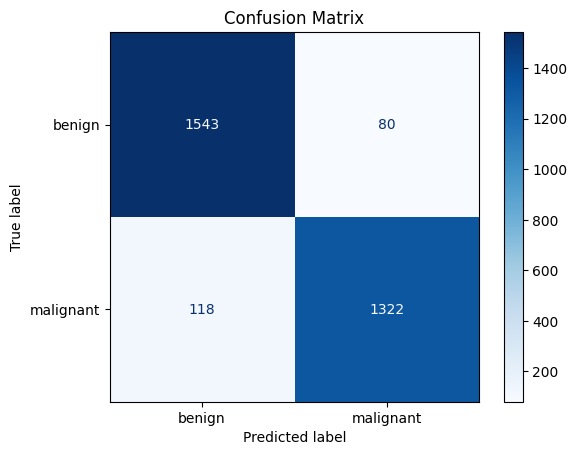

In [8]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [10]:
import torch

save_path = r"C:\Users\Samarth Kadam\Documents\Skin_cancer_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to C:\Users\Samarth Kadam\Documents\Skin_cancer_model.pth


C:\Users\Samarth Kadam\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Samarth Kadam\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Correct predictions: 30 / 30


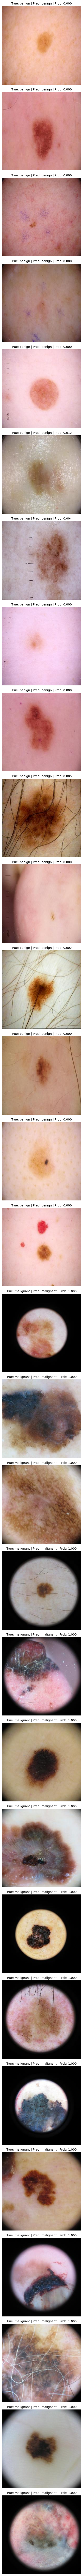

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 array([2.9288131e-07, 2.8696838e-06, 1.3807412e-04, 6.6533670e-05,
        1.4012543e-08, 1.2116339e-02, 3.5296082e-03, 4.1956349e-07,
        7.5043834e-05, 5.0929640e-03, 1.7203047e-06, 2.1666815e-03,
        9.1910880e-07, 1.6601360e-04, 2.0961749e-04, 1.0000000e+00,
        1.0000000e+00, 9.9987161e-01, 1.0000000e+00, 1.0000000e+00,
        9.9999976e-01, 1.0000000e+00, 9.9999571e-01, 1.0000000e+00,
        9.9999011e-01, 9.9998760e-01, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00], dtype=float32))

In [11]:
model = models.resnet34(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load(r"C:\Users\Samarth Kadam\Documents\Skin_cancer_model.pth", map_location='cpu'))  # use 'cuda' if needed
model.eval()

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_paths = [
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9631.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9632.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9633.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9634.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9635.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9636.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9622.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9623.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9624.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9625.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9626.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9627.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9628.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9629.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\benign\melanoma_9630.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10370.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10356.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10357.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10358.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10359.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10360.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10361.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10362.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10363.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10364.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10365.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10366.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10367.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10368.jpg",
    r"C:\Users\Samarth Kadam\Downloads\Melanoma Skin Cancer Dataset of 10000 Images\melanoma_cancer_dataset\test\malignant\melanoma_10369.jpg"
]
true_labels = [0]*15 + [1]*15  # cus if u look at the first 15 are benign and the other 15 are malignant so bengign is 0 and the other 1 :)

class_names = ['benign', 'malignant']

def batch_predict_and_show_vertical(img_paths, true_labels, model, transform, class_names):
    model.eval()
    imgs = []
    for path in img_paths:
        img = Image.open(path).convert("RGB")
        imgs.append(transform(img))
    batch = torch.stack(imgs).to(next(model.parameters()).device)
    with torch.no_grad():
        outputs = model(batch)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = [1 if p > 0.5 else 0 for p in probs]
    correct = sum([pred == true for pred, true in zip(preds, true_labels)])
    print(f"Correct predictions: {correct} / {len(img_paths)}")
    fig, axes = plt.subplots(len(img_paths), 1, figsize=(5, 4*len(img_paths)))
    if len(img_paths) == 1:
        axes = [axes]
    for i, path in enumerate(img_paths):
        img = Image.open(path).convert("RGB")
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"True: {class_names[true_labels[i]]} | Pred: {class_names[preds[i]]} | Prob: {probs[i]:.3f}", fontsize=10)
    plt.tight_layout()
    plt.show()
    return preds, probs

batch_predict_and_show_vertical(img_paths, true_labels, model, test_transform, class_names)
